In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import dateutil.parser
from datetime import timedelta
import datetime
import time
import os
import pandas as pd
import csv
#from IPython.display import Image, display
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from collections import OrderedDict

In [2]:
def read_tracker_data(csv_file, row):
    df = pd.read_csv(csv_file)
    sleep_interval = np.array([int(x) for x in df.iloc[row]["duration"].replace('[', '').replace(']','').split(',')])
    sleep_event = np.array([int(x) for x in df.iloc[row]["value"].replace('[', '').replace(']','').split(',')])
    #c = [colors[i] for i in sleep_event]
    sleep_begin = dateutil.parser.parse(df.iloc[row]["start"]) - timedelta(minutes=22)
    sleep_end = sleep_begin + timedelta(seconds=int(sleep_interval.sum()))
    sleep_duration = []
    s = sleep_begin.replace(tzinfo=None)
    timestamps = []
    for dur in sleep_interval:
        timestamps += [s.timestamp()]
        s += timedelta(seconds=int(dur))
    return sleep_interval, sleep_event, timestamps


In [3]:
def read_images(path, imageset):
    images = sorted(glob.glob(path + '*.png'))
    #print(datetime.utcfromtimestamp(int(os.path.getmtime(images[0]))))
    #image_time_begin = datetime.utcfromtimestamp(int(os.path.getmtime(images[0]))) + timedelta(hours=1)
    image_time_begin = datetime.datetime.strptime(path.split('/')[-2],'%Y-%m-%d-%Hh%Mm%Ss')
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows=False)

    stats = []
    if imageset == 'gray' or imageset == 'histogram':
        for image in tqdm_notebook(images):
            image = cv2.imread(image)
            fgmask = fgbg.apply(image)
            fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
            stats += [fgmask.sum()]
        print(imageset)
        print(path)
        
    if imageset == 'blur' or imageset == 'histogram_blur':
        for image in tqdm_notebook(images):
            image = cv2.imread(image)
            blur = cv2.GaussianBlur(image, (5,5),-1)
            fgmask = fgbg.apply(blur)
            fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
            stats += [fgmask.sum()]
        print(imageset)
        print(path)
    return stats, image_time_begin


In [4]:
interval, events, stamps = read_tracker_data('./sleep/sleep_raw.csv', 2)
sleep_states = np.dstack((events,stamps)).squeeze()

'''imagesets = {
    'gray' : './sleep/2018-11-25-20h28m08s/',
    'blur' : './sleep/2018-11-25-20h28m08s/',
    'histogram' : './2018-11-25-20h28m08s/',
    'histogram_blur' : './2018-11-25-20h28m08s/',
}
'''
imagesets = OrderedDict(
    [('gray', './sleep/2018-11-25-20h28m08s/'),
    ('blur', './sleep/2018-11-25-20h28m08s/'),
    ('histogram', './2018-11-25-20h28m08s/'),
    ('histogram_blur', './2018-11-25-20h28m08s/')
])

chunk_sizes_to_eval = [0.5, 1, 3, 5, 10, 15]
distance_tot = []
states_tot =[]
time_tot=[]
for imageset, path in imagesets.items():
    stats, image_time_begin = read_images(path, imageset)
    distance_chunk = []
    states_tot1 = []
    time_tot1 = []
    for eval_chunk_size in chunk_sizes_to_eval:
        fps = 3
        chunks_in_seconds = int(60 * eval_chunk_size)
        chunks = fps * chunks_in_seconds
        num_chunks = len(stats) // chunks
        diffs = []
        overlap = fps * 0
        for chunk_index in(range(0, num_chunks)):
            start = chunk_index * chunks
            start = min(start, abs(chunk_index * chunks - overlap))
            r = slice(start, start + chunks)
            arr = np.array(stats[r])
            diffs += [np.mean(np.array(stats[r]))]

        diffs = np.array(diffs)
        diffs = np.where(diffs > np.mean(diffs) * 0.5, 1, 2)
        nx = np.array(range(len(diffs)))
        offset = 3 * chunks_in_seconds
        #time = [image_time_begin + timedelta(seconds=int(x * chunks_in_seconds + offset)) for x in nx + 1]
        time = [int((image_time_begin + datetime.timedelta(seconds=int(x * chunks_in_seconds + offset))).timestamp()) for x in nx + 1]
        states = []
        duration = []
        last = None
        cnt = 0
        for i, v in enumerate(diffs):
            if v != last:
                states += [v]

                if last is not None:
                    duration += [cnt * chunks / fps ]
                    cnt = 0
            cnt += 1
            last = v

            if i == len(diffs) - 1:
                duration += [cnt * chunks / fps ]

        states = np.array(states)
        duration = np.array(duration)
        s = image_time_begin + timedelta(seconds=offset)
        time = []
        for dur in duration:
            time += [s]
            s += timedelta(seconds=dur)

        # process data for evaluation

        motion_time = [round(x.timestamp()) for x in time]
        motion_states = np.dstack((states,motion_time)).squeeze()

        distance, _ = fastdtw(sleep_states, motion_states, dist=euclidean)
        distance_chunk.append(distance)
        states_tot1.append(states)
        time_tot1.append(motion_time)
    distance_tot.append(distance_chunk)
    states_tot.append(states_tot1)
    time_tot.append(time_tot1)
        
print(distance_tot)
        # save dist, chunk_size, imageset in csv



gray
./sleep/2018-11-25-20h28m08s/



blur
./sleep/2018-11-25-20h28m08s/



histogram
./2018-11-25-20h28m08s/



histogram_blur
./2018-11-25-20h28m08s/
[[128460.34325842836, 121060.3615664457, 71960.4398202195, 70656.07640899548, 41448.01492523928, 50460.02026500087], [131760.3452682175, 124856.36540259114, 72560.43836730393, 76208.07426614097, 42648.01485005645, 40348.02380206129], [127112.29819423017, 121664.37548614624, 71448.39215012388, 64296.07784256732, 45604.01304870216, 51660.02171570038], [127126.30010745204, 123596.37052525232, 71516.39104965687, 68752.07270970504, 45604.01304870216, 52124.02534731449]]


In [5]:
chunk_size = [0.5, 1, 3, 5, 10, 15]
for chunksizes in range(len(chunk_size)):
    filenames = ['chunk(0.5)', 'chunk(1)', 'chunk(3)', 'chunk(5)','chunk(10)', 'chunk(15)']
    column_names = ['Chunksize', 'Imageset', 'Distance']
    data = pd.DataFrame(columns=column_names)
    imageset = ['gray', 'gray_blur', 'histogram', 'histogram_blur']
    for exp in range(len(imageset)):
        data.loc[exp] = [chunk_size[chunksizes], str(imageset[exp]), distance_tot[exp][chunksizes]]
        data.to_csv(filenames[chunksizes] + '.csv', index=False)
    

In [6]:
import os
path = os.getcwd()

In [7]:
chunk1 = pd.read_csv(path + '/chunk(0.5).csv')
chunk2 = pd.read_csv(path + '/chunk(1).csv')
chunk3 = pd.read_csv(path + '/chunk(3).csv')
chunk4 = pd.read_csv(path + '/chunk(5).csv')
chunk5 = pd.read_csv(path + '/chunk(10).csv')
chunk6 = pd.read_csv(path + '/chunk(15).csv')

In [8]:
y1 = list(chunk1['Distance'])
y2 = list(chunk2['Distance'])
y3=  list(chunk3['Distance'])
y4 = list(chunk4['Distance'])
y5 = list(chunk5['Distance'])
y6 = list(chunk6['Distance'])

In [9]:
y_tot = [y1, y2, y3, y4, y5, y6]

In [10]:
bars=[]
for bar in range(len(y1)):
    bars.append([y1[bar], y2[bar], y3[bar], y4[bar], y5[bar], y6[bar]])

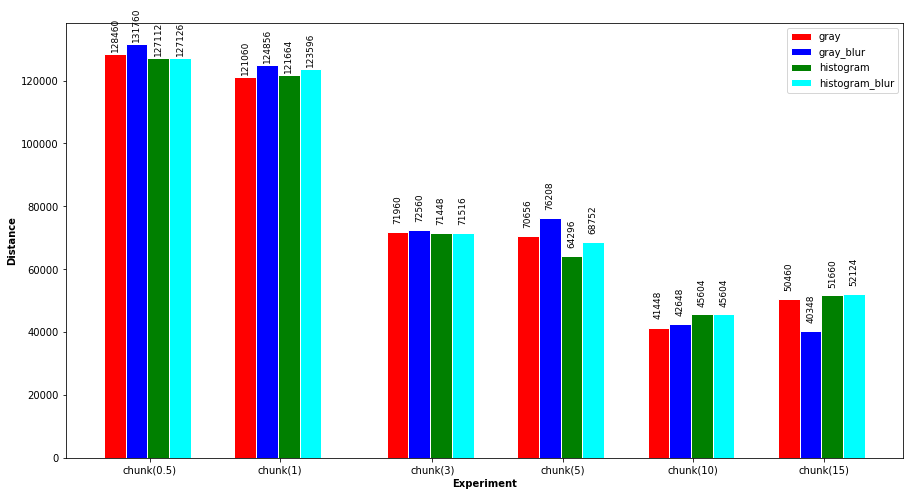

In [11]:
x = chunk1['Imageset']
chunk_size = [0.5, 1, 3, 5, 10, 15]
barwidth = 0.25
r1 = [0, 1.5, 3.25, 4.75, 6.25, 7.75]
r2 = [num + barwidth for num in r1]
r3 = [num + barwidth for num in r2]
r4 = [num + barwidth for num in r3]
r5 = r1+r2+r3+r4
bars_tot = bars[0]+bars[1]+bars[2]+bars[3]
labels = [int(round(x)) for x in bars_tot]

plt.figure(figsize=(15,8))
plt.bar(r1, bars[0], color = 'r', width = barwidth, edgecolor='white', label= 'gray')
plt.bar(r2, bars[1], color = 'b', width = barwidth, edgecolor='white', label= 'gray_blur')
plt.bar(r3, bars[2], color = 'g', width = barwidth, edgecolor='white', label= 'histogram')
plt.bar(r4, bars[3], color = 'cyan', width = barwidth, edgecolor='white', label= 'histogram_blur')

plt.xlabel('Experiment', fontweight= 'bold')
plt.ylabel('Distance', fontweight = 'bold')
plt.xticks([0.4, 1.9, 3.65, 5.15, 6.65, 8.15], ['chunk(0.5)', 'chunk(1)', 'chunk(3)', 'chunk(5)', 'chunk(10)', 'chunk(15)'])
plt.legend()

for i in range(len(r5)):
    plt.text(x = r5[i]-0.05, y = bars_tot[i]+9500, s = labels[i], size = 9, rotation =90)

#plt.savefig("/home/hrishkeshpattepu/Clahe_contraststretching/dataset2_test.png")
plt.show()


In [ ]:
r+0.2 + barwidth for r in range(len(bars[0]))